# Noiseless simulation of the FSL method

In this notebook, we present a step-by-step tutorial on implementing and using the FSL method to load a periodic, univariate function into a quantum state.

We first import useful libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Qiskit 
import qiskit
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.circuit.library import QFT

# Custom libraries
import supplementary
import uniformly_controlled_rotations as UCR

## The FSL method

Given a function $f: [0,1] \to \mathbb{C}$, the task of a function loading method is to prepare, with high fidelity, an $n$-qubit state $|{f}\rangle \, = \, \sum_{k=0}^{2^{n}-1} f_{k} |k\rangle \, ,$ where $f_{k} = f(k/2^{n}) \, $. While this can always be accompolished with a quantum circuit of $O(2^{n})$ depth and with $O(2^{n})$ quantum gates, the challenge is to do it using $O($poly$(n))$ resources.  

The FSL method exploits the fact that any function $f$ can be well-approximated by a truncated Fourier series. That is,

$$ f(x) \approx f_{(m)}(x) = \sum_{\ell = -2^{m}+1}^{2^{m}-1} \, c_{\ell} e^{-i2\pi \ell x} \, . $$

The FSL method loads $f_{(m)}(x)$ on a quantum state and prepares $|f_{m}\rangle$ using a quantum circuit of $O(n)$ depth and with $O(n^{2})$ quantum gates. Since $f_{(m)}$ is a good approximation of the target function $f$, the prepared state $|f_{(m)}\rangle$ is a good approximation of the target state $|f\rangle$.

Therefore, the first step in implementing the FSL method is to find a Fourier series approximation $f_{(m)}$ of the function $f$. The second step is to find an unitary $U_{c}$ which loads Fourier coefficients $c_{\ell}$ for $-2^{m} < \ell < 2^{m}$ into an $(m+1)$ qubit state. Explicitly, $U_{c}$ maps $|0\rangle^{\otimes (m+1)}$ to

$$ |\tilde{c}\rangle \, \sim \, \sum_{\ell=0}^{2^{m}-1} \, c_{\ell} |\ell\rangle \, + \, \sum_{\ell=1}^{2^{m}-1} \, c_{-\ell} |2^{m+1}-\ell\rangle \, , $$

where $\sim$ denotes equality up to a normalization constant. Once a suitable unitary $U_{c}$ is found, the Fourier series approximation $f_{(m)}$ is loaded on a quantum state of $n$ qubits using the following quantum circuit.  


<img src="figures/circuit_fsl.jpg" width="550"/>

In the rest of the notebook, we present the codes to perform the aforementioned steps for implementing the FSL method. We demonstrate its functionality via a quantum simulation of loading the reflected put option function into a state of $n=20$ qubits. We perform this simulation using the Qiskit Aer `statevector_vector` simulator. 

## Reflected Put Option Function

In [2]:
# no. of qubits 
n = 20 
# Discretizing the domain [0,1] into 2^n uniformly spaced points
x = [k/(2**n) for k in range(2**n)]

#Qiskit quantum state vector simulator
simulator = Aer.get_backend('statevector_simulator')

The reflected put option function is given by $f(x) = \mathcal{N}^{-1/2} \text{max}\big\{ K - e^{1-|2x-1|} \, , 0 \big\} \, $, where $\mathcal{N}$ is chosen such that the state $|f\rangle$ is normalized. For concreteness, we take $K = 2$. This is an interesting example as this function is defined piecewise. Despite that, we will still be able to load this function into a quantum state using the FSL method. 

We start by storing the elements of the state $|f\rangle$ as a list with identifier `target_f`:

In [3]:
# Target function
target_f = [max(2-np.exp(1-np.abs(2*xx-1)),0) for xx in x]
target_f = target_f/np.linalg.norm(target_f)

As discussed above, we need to approximate this function by a truncated Fourier series. In other words, we need to find the first few Fourier coefficients of this function. We do this using the fast discrete Fourier transform method. In fact, we have defined a function `Fourier_state` in the code file `supplementary.py`, which takes as an input a `list` $f$ and an `int` $m$ and returns a `list` of length $2^{(m+1)}$, $[c_{0}, c_{1}, \dots , c_{2^{m}-1}, 0, c_{-2^{m}+1}, \dots, c_{-1} ] \, $, where $c_{\ell}$ are the discrete Fourier coeffiecents of $f$. 

For concreteness, we choose $m=6$, and find the elements of the state $|\tilde{c}\rangle$ using the `Fourier_state` function. 

In [4]:
# No. of Fourier modes
# is 2^(m+1)
m = 6

# |c> with first 2^(m+1)
# Fourier modes
state_c = supplementary.Fourier_state(target_f,m)

The next step is to find a unitary $U_{c}$ defined above. We implement this unitary using a cascade of uniformly controlled rotations, which can be used to prepare an arbitrary state. All the angles of uniformly controlled rotations needed to prepare a given state can exactly be determined with a few lines of codes. The file `uniformly_controlled_rotations.py` contains codes to calculate the angles of rotations, and implement an efficient decomposition of the uniformly controlled rotations in terms of CNOTs and single-qubit rotation gates. In particular, the function `cascade_UCRs` takes a `list` of length $2^{n}$ of the form $[\psi_{0},\psi_{1}, \dots, \psi_{2^{n}-1}]$ and returns the cascade of uniformly controlled rotations implemented as a Qiskit `QuantumCircuit` that maps $|0\rangle^{\otimes n}$ to $\sum_{k=0}^{2^{n}-1} \psi_{k}|k\rangle \, $. Applying this function to `state_c` will give us an implementation of $U_{c}$:

In [5]:
U_c = UCR.cascade_UCRs(state_c)

Now that we have the quantum circuit $U_{c}$, we can prepare and run the circuit shown above. 

In [6]:
# Initialize a quantum circuit
circ = QuantumCircuit(n)

# Apply U_c on the last (m+1) qubits
Uc_qubits = range(n-m-1,n)
circ.compose(U_c,qubits=Uc_qubits,inplace=True)

# Apply a cascade of CNOTs
for i in range(n-m-1):
    circ.cx(n-m-1,i)

# Finally, apply the inverse QFT.
inv_qft = QFT(num_qubits=n, inverse=True)
inv_qft = transpile(inv_qft, simulator)
# Note that Qiskit uses the opposite 
# qubit ordering. 
circ.compose(inv_qft,qubits=range(n-1,-1,-1),inplace=True)

# Run the circuit
# and get the statevector
job = simulator.run(circ)
output_state = job.result().get_statevector(circ)

Before we analyze the output of the simulation that we have just performed, we observe that the Qiskit uses a different qubit ordering convention than the one we have been using. For example, the state we label by $|001\rangle$ is alternatively labelled by $|100\rangle$ according to the convention used by Qiskit. Therefore, we have to make sure that we perform the necessary reordering before analyzing the output of the above simulation. This is achieved by the function `output_reordering` which we have defined in the code file `supplementary.py`. This function takes the result of the simulation performed in Qiskit, and returns the output which is consistent with our qubit-ordering conventions. 

In [7]:
# Reordering qubits
simulated_f = supplementary.output_reordering(output_state)

We can present the result of the simulation by plotting the amplitudes of the state prepared using the FSL method, `simulated_f`, together with the amplitudes of the target state, `target_f`. 

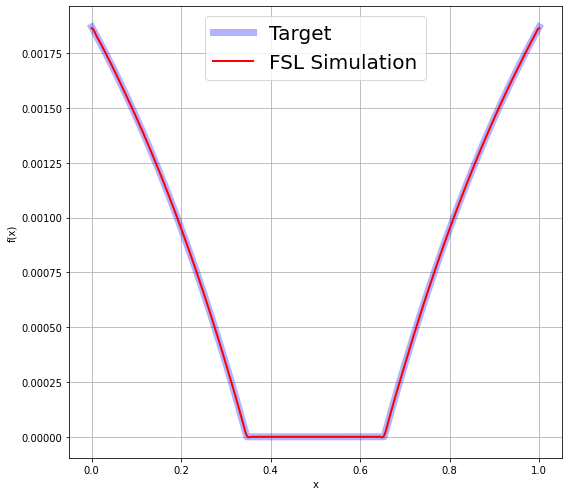

In [8]:
# Plottting the simulated statevectors 
fig=plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111)
plt.grid()
line, = ax.plot(x, target_f, 'blue', lw=7, alpha=0.3,label='Target')
line1, = ax.plot(x, np.real(simulated_f), 'red', lw=2,label='FSL Simulation')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend(loc=9,fontsize=20)
plt.tight_layout()
plt.show()

It is apparent from the above figure that we have successfully loaded the reflected put option function on a quantum state of $20$ qubits with high fidelity. We can quantify the error between the prepared state and the target state in terms of the infidelity between these states. The infidelity between states $|f_{1}\rangle$ and $|f_{2}\rangle$ is defined as

$$ \epsilon \, \equiv \, 1 - \left| \langle f_{1} | f_{2} \rangle \right|^{2} \, . $$

We now calculate the infidelity between two target state and the simulated state:

In [9]:
# Calculate infidelity
infidelity = 1 - np.abs(np.dot(np.conjugate(simulated_f),target_f))**2
print(infidelity)

2.9379419719255395e-07


## Conclusion

In this notebook, we have presented the codes to perform the simulation of the FSL method. In doing so, we have also provided a step-by-step tutorial on implementing the FSL method. 